# Includes:

In [6]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from data_paths import get_file_paths_ordered
from tf_lite_conversion import convert_to_tf_lite, eval_tf_lite_model
from scipy.io import wavfile
from IPython.display import Audio
from pre_process import choose_tot_slice_len, get_data_tensors, compute_mfccs
from models import get_model

In [95]:
NB_SPEAKERS = 5
dataset_percentage = 1 # 0.85
segmentLength=1024
print("Number of speakers : ", NB_SPEAKERS)

CSV_DIR = 'csv/'
MODEL_NAME =  str(NB_SPEAKERS) + '_qkeras'
TFLITE_MODEL_NAME = 'tflite_'+ MODEL_NAME[:-3]
C_MODEL_NAME = MODEL_NAME[:-3]

MODEL_DIR = 'Models/' + MODEL_NAME + '/'
# Create model directory
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
print("Model folder : ", MODEL_DIR)
print("Model names : ", MODEL_NAME,TFLITE_MODEL_NAME, C_MODEL_NAME)

Number of speakers :  5
Model folder :  Models/5_qkeras/
Model names :  5_qkeras tflite_5_qke 5_qke


Read data:

Total number of speakers in the original dataset: 20
Original number of files per speaker :  [1002, 656, 589, 570, 489]
Training number of files per speaker :  2260


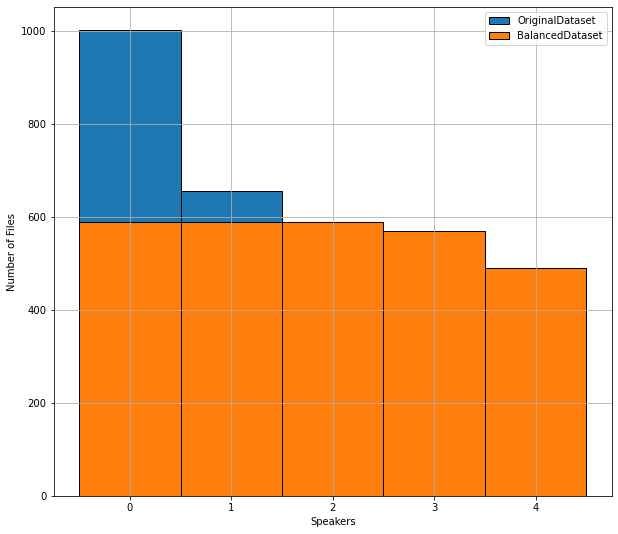

In [8]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l  = get_file_paths_ordered(num_speaker = NB_SPEAKERS, 
                                                                                    test_ratio = 0.2,
                                                                                    balanced_dataset = True, 
                                                                                    plot_data = True)

Visualization of the samples ...


100%|██████████████████████████████████████████████████████████████████████████| 2826/2826 [00:11<00:00, 251.42it/s]


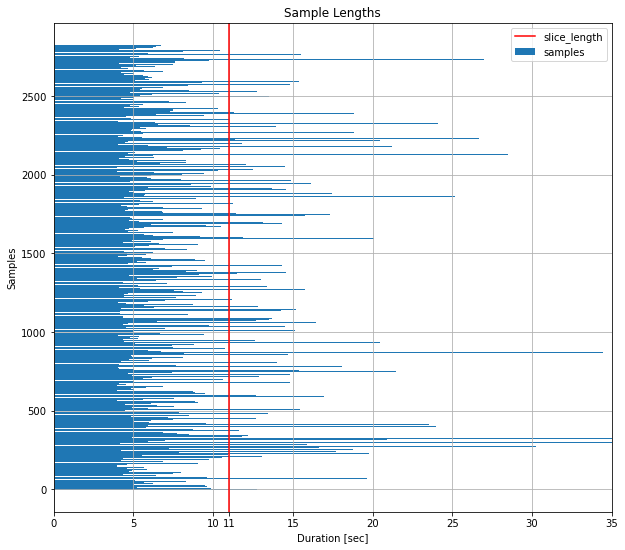

Visualization of the samples ...


100%|█████████████████████████████████████████████████████████████████████████| 2826/2826 [00:01<00:00, 1800.17it/s]


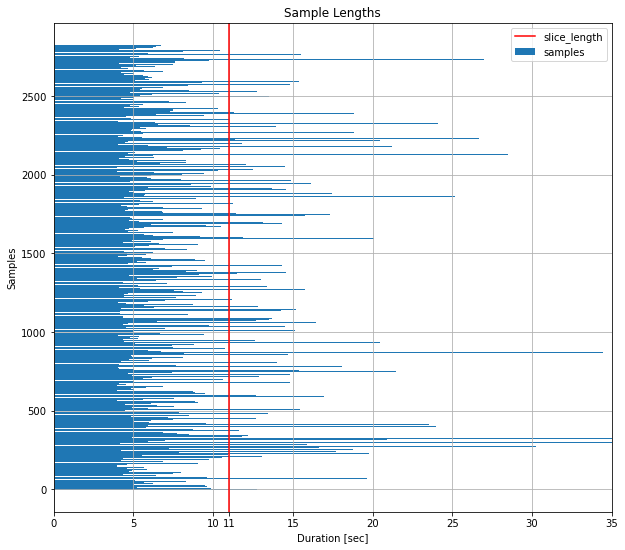

100%|████████████████████████████████████████████████████████████████████████████| 566/566 [00:01<00:00, 365.80it/s]


In [9]:
seg_len = choose_tot_slice_len(paths=all_paths_l, visualize=True)
slice_len = choose_tot_slice_len(paths=all_paths_l, visualize=True)

f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                         y_train_l=y_train_l, y_test_l=y_test_l,
                                                         tot_slice_len=slice_len,
                                                         used_train_sz_rat=dataset_percentage, 
                                                         used_test_sz_rat=1.,
                                                         segmentLength=segmentLength)

In [10]:
# play a random sample
i=1
fs_i, audio_data_i = wavfile.read(paths_train[i])
display(Audio(audio_data_i, rate=fs_i))

# Pre-Processing:

In [12]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13

with tf.device("/cpu:0"):
    x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
    x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

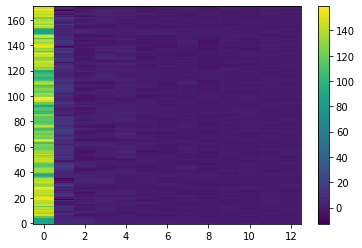

In [13]:
plt.figure()
plt.imshow(x_train_mfcc[i], interpolation="nearest", origin="lower", aspect="auto")
plt.colorbar()

# Define the Model:

In [14]:
train_set = x_train_mfcc
test_set = x_test_mfcc
print(train_set.shape)

(2260, 171, 13, 1)


# Keras Model

In [92]:
model_idx = 0
input_shape = train_set.shape
model = get_model(input_shape=input_shape, nb_classes=NB_SPEAKERS, model_idx=model_idx)
model.build(input_shape=input_shape)
#model.summary()

In [96]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 150 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

model.compile(
    loss=loss_fct, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_keras_best.h5',save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1.0e-5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),       
]

history= model.fit(
    x=train_set, 
    y=y_train, 
    batch_size=batchSize, 
    epochs=epochs, 
    validation_split=0.2,
    callbacks = callbacks
)

Epoch 1/150
57/57 [==============================] - 9s 59ms/step - loss: 1.1655 - accuracy: 0.5138 - val_loss: 1.6251 - val_accuracy: 0.1858 - lr: 0.0010
Epoch 2/150
57/57 [==============================] - 3s 46ms/step - loss: 0.6168 - accuracy: 0.8003 - val_loss: 2.0840 - val_accuracy: 0.1858 - lr: 0.0010
Epoch 3/150
57/57 [==============================] - 3s 46ms/step - loss: 0.4599 - accuracy: 0.8639 - val_loss: 2.6958 - val_accuracy: 0.1858 - lr: 0.0010
Epoch 4/150
57/57 [==============================] - 3s 46ms/step - loss: 0.3651 - accuracy: 0.8850 - val_loss: 2.3649 - val_accuracy: 0.1925 - lr: 0.0010
Epoch 5/150
57/57 [==============================] - 3s 45ms/step - loss: 0.2764 - accuracy: 0.9148 - val_loss: 2.1581 - val_accuracy: 0.2522 - lr: 0.0010
Epoch 6/150
57/57 [==============================] - 3s 45ms/step - loss: 0.2326 - accuracy: 0.9331 - val_loss: 2.7868 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 7/150
57/57 [==============================] - 3s 45ms/step - lo

In [97]:
y_pred = model.predict(test_set)

test_loss, test_acc = model.evaluate(test_set,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 1s 13ms/step
18/18 - 0s - loss: 0.7246 - accuracy: 0.8339 - 281ms/epoch - 16ms/step
Test accuracy: 0.833922266960144
Test loss: 0.72463059425354


In [100]:
model_save_path = MODEL_DIR + MODEL_NAME + '_keras_.h5'
model.save(model_save_path)

In [101]:
# Show the model size for Keras model 
h5_in_kb = os.path.getsize(model_save_path) / 1024
print("QKeras Model file : ", model_save_path)
print("QKeras Model size without quantization: %d KB" % h5_in_kb)

QKeras Model file :  Models/5_qkeras/5_qkeras_keras_.h5
QKeras Model size without quantization: 387 KB


# QKeras Model

In [66]:
def qmodel(input_shape, nb_classes):

    model = tf.keras.models.Sequential()
    #Normalize data
    model.add(layers.Normalization())

    model.add(QConv2D(filters=3, kernel_size=(3,3), padding="same", input_shape=input_shape,
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = False, # less parameters ? 
                      name="conv2d_1"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_1"))

    model.add(QConv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="binary(alpha=1)", 
                      use_bias = False,     
                      name="conv2d_2"))    
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_2"))

    model.add(layers.MaxPool2D((2,2)))

    model.add(QConv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = False, # less parameters ? 
                      name="conv2d_3"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_3"))

    model.add(layers.MaxPool2D((2,2)))

    model.add(QConv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = False, # less parameters ? 
                      name="conv2d_4"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_4"))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Flatten())

    model.add(QDense(8, kernel_regularizer=(regularizers.l1(0)),
                     kernel_quantizer="binary(alpha=1)",
                     bias_quantizer="binary(alpha=1)",
                     name="dense_1"))
    model.add(QActivation("quantized_relu(2)", name="act_5"))

    model.add(QDense(nb_classes,
                     kernel_quantizer="binary(alpha=1)",
                     bias_quantizer="binary(alpha=1)",
                     name="dense_2"))  # Nb classes to recognize
    model.add(QActivation("softmax", name="softmax"))  # Softmax to get probas of each class
    

    return model

In [67]:
qmodel = qmodel(train_set.shape, NB_SPEAKERS)
qmodel.build(input_shape=train_set.shape)
qmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (2260, 171, 13, 1)       3         
 ion)                                                            
                                                                 
 conv2d_1 (QConv2D)          (2260, 171, 13, 3)        27        
                                                                 
 batch_normalization_22 (Bat  (2260, 171, 13, 3)       12        
 chNormalization)                                                
                                                                 
 act_1 (QActivation)         (2260, 171, 13, 3)        0         
                                                                 
 conv2d_2 (QConv2D)          (2260, 86, 7, 16)         432       
                                                                 
 batch_normalization_23 (Bat  (2260, 86, 7, 16)       

Define learning parameters:

In [68]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 150 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

Compile the model and Fit the Data:\
@TODO use weights giving the highest accuracy on the validation dataset

In [69]:
qmodel.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_qkeras_best.h5',save_best_only=True,verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),       
]

history = qmodel.fit(
    x = train_set, 
    y = y_train, 
    validation_split=0.2,
    callbacks = callbacks, 
    batch_size = batchSize, 
    epochs = epochs
)

Epoch 1/150
56/57 [============================>.] - ETA: 0s - loss: 1.8533 - accuracy: 0.1869
Epoch 1: val_loss improved from inf to 2.01532, saving model to Models\5_qkeras_qkeras_best.h5
57/57 [==============================] - 11s 83ms/step - loss: 1.8518 - accuracy: 0.1881 - val_loss: 2.0153 - val_accuracy: 0.1836 - lr: 0.0010
Epoch 2/150
56/57 [============================>.] - ETA: 0s - loss: 1.8371 - accuracy: 0.2009
Epoch 2: val_loss did not improve from 2.01532
57/57 [==============================] - 3s 60ms/step - loss: 1.8370 - accuracy: 0.2019 - val_loss: 2.4641 - val_accuracy: 0.2190 - lr: 0.0010
Epoch 3/150
56/57 [============================>.] - ETA: 0s - loss: 1.8283 - accuracy: 0.1936
Epoch 3: val_loss did not improve from 2.01532
57/57 [==============================] - 3s 58ms/step - loss: 1.8273 - accuracy: 0.1936 - val_loss: 2.1162 - val_accuracy: 0.2190 - lr: 0.0010
Epoch 4/150
56/57 [============================>.] - ETA: 0s - loss: 1.8183 - accuracy: 0.2003
E

Epoch 28/150
57/57 [==============================] - ETA: 0s - loss: 1.7090 - accuracy: 0.2600
Epoch 28: val_loss did not improve from 1.60783
57/57 [==============================] - 3s 56ms/step - loss: 1.7090 - accuracy: 0.2600 - val_loss: 1.7484 - val_accuracy: 0.2279 - lr: 0.0010
Epoch 29/150
56/57 [============================>.] - ETA: 0s - loss: 1.6990 - accuracy: 0.2779
Epoch 29: val_loss did not improve from 1.60783
57/57 [==============================] - 3s 59ms/step - loss: 1.6978 - accuracy: 0.2777 - val_loss: 1.7397 - val_accuracy: 0.2279 - lr: 0.0010
Epoch 30/150
57/57 [==============================] - ETA: 0s - loss: 1.6764 - accuracy: 0.2860
Epoch 30: val_loss improved from 1.60783 to 1.56908, saving model to Models\5_qkeras_qkeras_best.h5
57/57 [==============================] - 3s 57ms/step - loss: 1.6764 - accuracy: 0.2860 - val_loss: 1.5691 - val_accuracy: 0.3119 - lr: 0.0010
Epoch 31/150
57/57 [==============================] - ETA: 0s - loss: 1.6867 - accuracy

Epoch 55/150
56/57 [============================>.] - ETA: 0s - loss: 1.4631 - accuracy: 0.3186
Epoch 55: val_loss did not improve from 1.39055
57/57 [==============================] - 3s 55ms/step - loss: 1.4670 - accuracy: 0.3169 - val_loss: 1.6077 - val_accuracy: 0.2279 - lr: 0.0010
Epoch 56/150
56/57 [============================>.] - ETA: 0s - loss: 1.4452 - accuracy: 0.3058
Epoch 56: val_loss did not improve from 1.39055
57/57 [==============================] - 3s 55ms/step - loss: 1.4431 - accuracy: 0.3086 - val_loss: 1.4626 - val_accuracy: 0.3031 - lr: 0.0010
Epoch 57/150
57/57 [==============================] - ETA: 0s - loss: 1.4236 - accuracy: 0.3385
Epoch 57: val_loss did not improve from 1.39055
57/57 [==============================] - 3s 54ms/step - loss: 1.4236 - accuracy: 0.3385 - val_loss: 1.6588 - val_accuracy: 0.2279 - lr: 0.0010
Epoch 58/150
56/57 [============================>.] - ETA: 0s - loss: 1.4176 - accuracy: 0.3309
Epoch 58: val_loss did not improve from 1.3

Epoch 83/150
56/57 [============================>.] - ETA: 0s - loss: 1.2502 - accuracy: 0.4325
Epoch 83: val_loss did not improve from 1.22203
57/57 [==============================] - 3s 56ms/step - loss: 1.2459 - accuracy: 0.4369 - val_loss: 1.3015 - val_accuracy: 0.5155 - lr: 0.0010
Epoch 84/150
56/57 [============================>.] - ETA: 0s - loss: 1.2647 - accuracy: 0.4392
Epoch 84: val_loss improved from 1.22203 to 1.19281, saving model to Models\5_qkeras_qkeras_best.h5
57/57 [==============================] - 3s 57ms/step - loss: 1.2627 - accuracy: 0.4392 - val_loss: 1.1928 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 85/150
57/57 [==============================] - ETA: 0s - loss: 1.2641 - accuracy: 0.4176
Epoch 85: val_loss did not improve from 1.19281
57/57 [==============================] - 3s 50ms/step - loss: 1.2641 - accuracy: 0.4176 - val_loss: 1.2865 - val_accuracy: 0.3872 - lr: 0.0010
Epoch 86/150
57/57 [==============================] - ETA: 0s - loss: 1.2531 - accuracy

Epoch 111/150
56/57 [============================>.] - ETA: 0s - loss: 1.1888 - accuracy: 0.4381
Epoch 111: val_loss did not improve from 1.13572
57/57 [==============================] - 3s 57ms/step - loss: 1.1876 - accuracy: 0.4403 - val_loss: 1.2975 - val_accuracy: 0.5664 - lr: 2.0000e-04
Epoch 112/150
56/57 [============================>.] - ETA: 0s - loss: 1.1689 - accuracy: 0.4436
Epoch 112: val_loss did not improve from 1.13572
57/57 [==============================] - 3s 54ms/step - loss: 1.1721 - accuracy: 0.4430 - val_loss: 1.2979 - val_accuracy: 0.3473 - lr: 2.0000e-04
Epoch 113/150
57/57 [==============================] - ETA: 0s - loss: 1.2089 - accuracy: 0.4093
Epoch 113: val_loss did not improve from 1.13572
57/57 [==============================] - 3s 54ms/step - loss: 1.2089 - accuracy: 0.4093 - val_loss: 1.3894 - val_accuracy: 0.3142 - lr: 2.0000e-04
Epoch 114/150
56/57 [============================>.] - ETA: 0s - loss: 1.1896 - accuracy: 0.4330
Epoch 114: val_loss did 


Epoch 138: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
57/57 [==============================] - 3s 58ms/step - loss: 1.1656 - accuracy: 0.4563 - val_loss: 1.1519 - val_accuracy: 0.3363 - lr: 2.0000e-04
Epoch 139/150
56/57 [============================>.] - ETA: 0s - loss: 1.1721 - accuracy: 0.4509
Epoch 139: val_loss did not improve from 1.10006
57/57 [==============================] - 3s 56ms/step - loss: 1.1715 - accuracy: 0.4502 - val_loss: 1.1525 - val_accuracy: 0.4226 - lr: 4.0000e-05
Epoch 140/150
56/57 [============================>.] - ETA: 0s - loss: 1.1644 - accuracy: 0.4152
Epoch 140: val_loss improved from 1.10006 to 1.09912, saving model to Models\5_qkeras_qkeras_best.h5
57/57 [==============================] - 3s 60ms/step - loss: 1.1649 - accuracy: 0.4148 - val_loss: 1.0991 - val_accuracy: 0.3518 - lr: 4.0000e-05
Epoch 141/150
57/57 [==============================] - ETA: 0s - loss: 1.1824 - accuracy: 0.4430
Epoch 141: val_loss did not improve fr

Evaluate the performance on the test set:

In [71]:
y_pred = qmodel.predict(test_set)

test_loss, test_acc = qmodel.evaluate(test_set,  y_test, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 0s 20ms/step - loss: 1.0648 - accuracy: 0.7049
Test accuracy: 0.7049469947814941
Test loss: 1.064794659614563


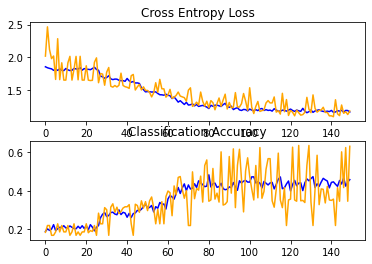

In [72]:
# learning curves
# plot diagnostic learning curves
import sys
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

In [73]:
print_qstats(qmodel)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    conv2d_1                      : 60021 (smult_8_8)
    conv2d_2                      : 260064 (smux_1_2)
    conv2d_3                      : 202752 (smult_8_2)
    conv2d_4                      : 110592 (smult_8_2)
    dense_1                       : 512   (smux_1_2)
    dense_2                       : 40    (smux_1_2)

Number of operation types in model:
    smult_8_2                     : 313344
    smult_8_8                     : 60021
    smux_1_2                      : 260616

Weight profiling:
    conv2d_1_weights               : 27    (8-bit unit)
    conv2d_1_bias                  : 0     (32-bit unit)
    conv2d_2_weights               : 432   (1-bit unit)
    conv2d_2_bias                  : 0     (32-bit unit)
    conv2d_3_weights               : 4608  (8-bit unit)
    conv2d_3_bias                  : 0     (32-bit unit)
    conv2d_4_weights               : 18432 (8-bit unit)
    conv2d_4_bias                  : 0     (32-bit unit)
    dens

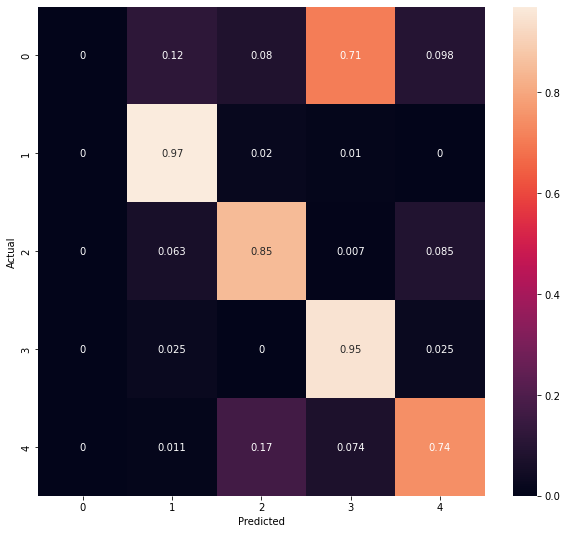

In [75]:
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [99]:
model_save_path = os.path.join(MODEL_DIR, MODEL_NAME + '.h5')
qmodel.save(model_save_path)

In [88]:
# Show the model size for QKeras model 
h5_in_kb = os.path.getsize(model_save_path) / 1024
print("QKeras Model file : ", model_save_path)
print("QKeras Model size without quantization: %d KB" % h5_in_kb)

QKeras Model file :  Models\5_qkeras\5_qkeras.h5
QKeras Model size without quantization: 387 KB


# TF Lite Conversion and Quantization:

In [24]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_DIR + MODEL_NAME) 

In [25]:
train_set = x_train_mfcc
train_set.numpy().shape

(1808, 171, 13, 1)

In [93]:
tflite_model = tf_lite_conversion.convert_to_tf_lite(x_train_mfcc,model,MODEL_DIR + TFLITE_MODEL_NAME)

INFO:tensorflow:Assets written to: C:\Users\erolland\AppData\Local\Temp\tmp6syxopk1\assets


INFO:tensorflow:Assets written to: C:\Users\erolland\AppData\Local\Temp\tmp6syxopk1\assets
C:\Apps\Anaconda3\envs\ml\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [83]:
# Show the model size for the non-quantized TFLite model
tflite_quant_in_kb = os.path.getsize(MODEL_DIR + TFLITE_MODEL_NAME + '.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (h5_in_kb / tflite_quant_in_kb))

TFLite Model size with 8-bit quantization: 28 KB

Reduction in model size by a factor of 11.581556


# C conversion

In [94]:
# Write TFLite model to a C source (or header) file
from c_code_conversion import *
with open(MODEL_DIR + C_MODEL_NAME + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, C_MODEL_NAME))

In [95]:
quan_test_dat_path = '../QuantizedTestData/'

# Create the directory
if not os.path.exists(quan_test_dat_path):
    os.makedirs(quan_test_dat_path)
    
# save the test data as numpy arrays
np.save(quan_test_dat_path + 'x_test_voxceleb.npy', tf.cast(x_test_mfcc, dtype=tf.uint8))#.astype(np.uint8))
np.save(quan_test_dat_path + 'y_test_voxceleb.npy', y_test)

#save_array_to_file(x_train.astype(np.uint8), y_train, 'X_train.csv', 'Y_train.csv', CSV_DIR)

# Test the model

We can test the model using the tflite interpreter. We can use the set_tensor() function to set the input data and the invoke() function to run the model. We can then use the get_tensor() function to get the output data. More information can be found in the tflite interpreter documentation.

In [96]:
# Test the model using the tflite interpreter with quantization
interpreter = tf.lite.Interpreter(model_path=MODEL_DIR+TFLITE_MODEL_NAME+'.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print some information about the input and output tensors
print("Input shape is {} and of type {}".format(input_details[0]['shape'], input_details[0]['dtype']))
print("Output shape is {} and of type {}".format(output_details[0]['shape'], output_details[0]['dtype']))
     

Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [1 5] and of type <class 'numpy.int8'>


In [97]:
input_data = tf.cast(tf.cast(x_test_mfcc, tf.int32)-128, tf.int8)
input_shape = input_details[0]['shape']
interpreter.resize_tensor_input(input_details[0]['index'], input_data.shape)
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [98]:
from sklearn.metrics import accuracy_score
print("Accuracy of quantized model is: ", accuracy_score(y_test, np.argmax(output_data, axis=1)))

Accuracy of quantized model is:  0.17314487632508835


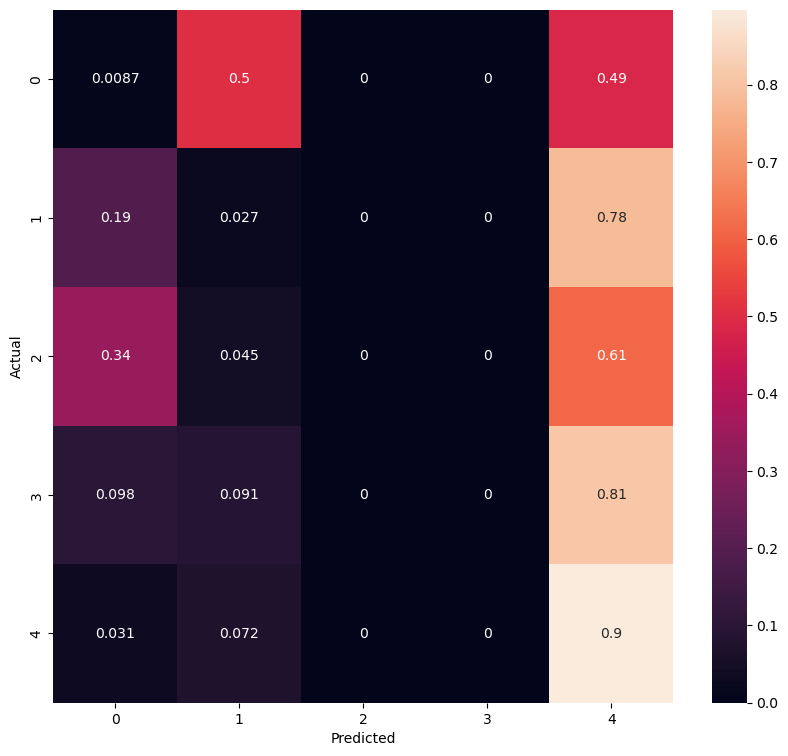

In [42]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, np.argmax(output_data, axis=1), 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [99]:
tflite_interpreter = tf.lite.Interpreter(model_path=MODEL_DIR+TFLITE_MODEL_NAME + '.tflite')
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_normalization_2_input:0
shape: [  1 171  13   1]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 5]
type: <class 'numpy.int8'>


In [100]:
test_set = x_test_mfcc
predictions = np.zeros((len(test_set),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(test_set)):
    val_batch = test_set[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
     

In [111]:
sum = 0
test_labels = y_test
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
        
tflite_score = accuracy_score(y_test, predictions)
print(sum, test_labels.shape, sum/len(test_labels))
print("Accuracy of quantized to int8 model is {}%".format(tflite_score*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_score-test_acc)*100))

557 (566,) 0.9840989399293286
Accuracy of quantized to int8 model is 98.40989399293287%
Compared to float32 accuracy of 99.46996569633484%
We have a change of -1.0600717034019769%


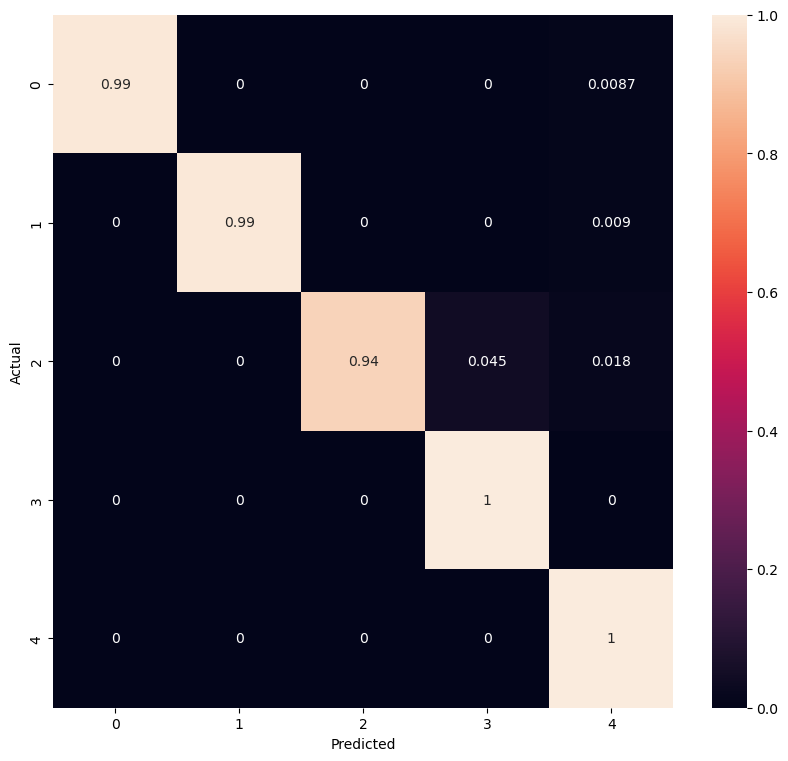

In [103]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, predictions, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()